Research Paper: https://arxiv.org/abs/1904.05068

2019 paper

Dataset: CIFAR 100

"Relational Knowledge Distillation" introduces a novel perspective to knowledge distillation by emphasizing the importance of pairwise relationships in the feature space and using them to distill knowledge from teacher to student models.

Code Link: https://github.com/lenscloth/RKD




In [1]:
!pip install torch torchvision --quiet

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load Data - CIFAR10
mean = [0.4914, 0.4822, 0.4465]
std = [0.2471, 0.2435, 0.2616]


train_transform = transforms.Compose([transforms.Pad(4),
                                      transforms.RandomCrop(32),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean, std=std)])

test_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Define the RKD distance and angle losses
def pairwise_distances(x, y):
    """
    Compute pairwise distances between the vectors in x and y
    Args:
    - x: A tensor of shape (batch_size, feature_dim)
    - y: A tensor of shape (batch_size, feature_dim)
    Returns:
    - pairwise_distances: Tensor of shape (batch_size, batch_size)
    """
    inner_product = torch.mm(x, y.t())
    x_norm = torch.norm(x, dim=1, keepdim=True)
    y_norm = torch.norm(y, dim=1, keepdim=True)
    distances = x_norm**2 - 2.0 * inner_product + y_norm.t()**2
    return distances

def DD_loss(student, teacher):
    """
    Distance-wise Distillation Loss
    """
    student_distances = pairwise_distances(student, student)
    teacher_distances = pairwise_distances(teacher, teacher)

    # We scale down the teacher distances to make it in range with the student's
    teacher_distances = teacher_distances / teacher_distances.detach().data.mean()
    student_distances = student_distances / student_distances.detach().data.mean()

    loss = F.mse_loss(student_distances, teacher_distances)
    return loss

def pairwise_angles(x, y):
    """
    Compute pairwise angles between the vectors in x and y
    """
    norm_x = torch.norm(x, dim=1, keepdim=True)
    norm_y = torch.norm(y, dim=1, keepdim=True)
    normalized_x = x / norm_x
    normalized_y = y / norm_y
    cosine_similarity = torch.mm(normalized_x, normalized_y.t())
    return cosine_similarity

def AD_loss(student, teacher):
    """
    Angle-wise Distillation Loss
    """
    student_angles = pairwise_angles(student, student)
    teacher_angles = pairwise_angles(teacher, teacher)

    loss = F.mse_loss(student_angles, teacher_angles)
    return loss


In [5]:
# Define RKD Losses
class RKDDistanceLoss(nn.Module):
    def __init__(self):
        super(RKDDistanceLoss, self).__init__()

    def forward(self, student, teacher):
        return F.pairwise_distance(student, teacher).mean()


class RKDAngleLoss(nn.Module):
    def __init__(self):
        super(RKDAngleLoss, self).__init__()

    def forward(self, student, teacher):
        # Normalize vectors
        student = F.normalize(student, dim=1)
        teacher = F.normalize(teacher, dim=1)

        # Get dot product between vectors
        dot = torch.matmul(student, teacher.t())
        return torch.mean(torch.acos(dot) ** 2)


In [6]:
# teacher = models.resnet18(pretrained=True, num_classes=10)
# student = models.resnet18(pretrained=False, num_classes=10)
# teacher = models.resnet50(num_classes=10)
# student = models.resnet50(num_classes=10)
# student = models.resnet18(num_classes=10)

teacher = models.resnet18(num_classes=10)
student = models.resnet18(num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher.to(device)
student.to(device)


# Training and Evaluation Utilities
optimizer = optim.Adam(student.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [7]:
def train_epoch(train_loader, student, teacher, optimizer, criterion):
    student.train()
    teacher.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        student_outputs = student(data)
        with torch.no_grad():
            teacher_outputs = teacher(data)

        loss = criterion(student_outputs, target) + 0.1 * (RKDDistanceLoss()(student_outputs, teacher_outputs) + RKDAngleLoss()(student_outputs, teacher_outputs))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = student_outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    avg_loss = total_loss / (batch_idx + 1)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

def evaluate(loader, model, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.cuda(), target.cuda()

            outputs = model(data)
            loss = criterion(outputs, target)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_loss = total_loss / (batch_idx + 1)
    accuracy = 100. * correct / total

    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    return avg_loss, accuracy, precision, recall, f1

In [8]:
# Training loop
epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1s = []

for epoch in range(epochs):
    train_loss, train_accuracy = train_epoch(train_loader, student, teacher, optimizer, criterion)
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_loader, student, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1s.append(test_f1)

    print(f"Epoch: {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")




Epoch: 1/20
Train Loss: 2.0511, Train Accuracy: 43.1780
Test Loss: 1.3553, Test Accuracy: 55.9600, Test Precision: 0.5754, Test Recall: 0.5596, Test F1: 0.5569
Epoch: 2/20
Train Loss: 1.7641, Train Accuracy: 57.2080
Test Loss: 1.2136, Test Accuracy: 61.1400, Test Precision: 0.6584, Test Recall: 0.6114, Test F1: 0.5877
Epoch: 3/20
Train Loss: 1.6166, Train Accuracy: 63.8620
Test Loss: 1.0612, Test Accuracy: 67.5100, Test Precision: 0.6829, Test Recall: 0.6751, Test F1: 0.6736
Epoch: 4/20
Train Loss: 1.5251, Train Accuracy: 67.8580
Test Loss: 0.9537, Test Accuracy: 70.8500, Test Precision: 0.7168, Test Recall: 0.7085, Test F1: 0.7076
Epoch: 5/20
Train Loss: 1.4546, Train Accuracy: 70.9280
Test Loss: 0.9197, Test Accuracy: 72.7100, Test Precision: 0.7368, Test Recall: 0.7271, Test F1: 0.7283
Epoch: 6/20
Train Loss: 1.4025, Train Accuracy: 72.9140
Test Loss: 0.9105, Test Accuracy: 73.1500, Test Precision: 0.7485, Test Recall: 0.7315, Test F1: 0.7330
Epoch: 7/20
Train Loss: 1.3635, Train Ac

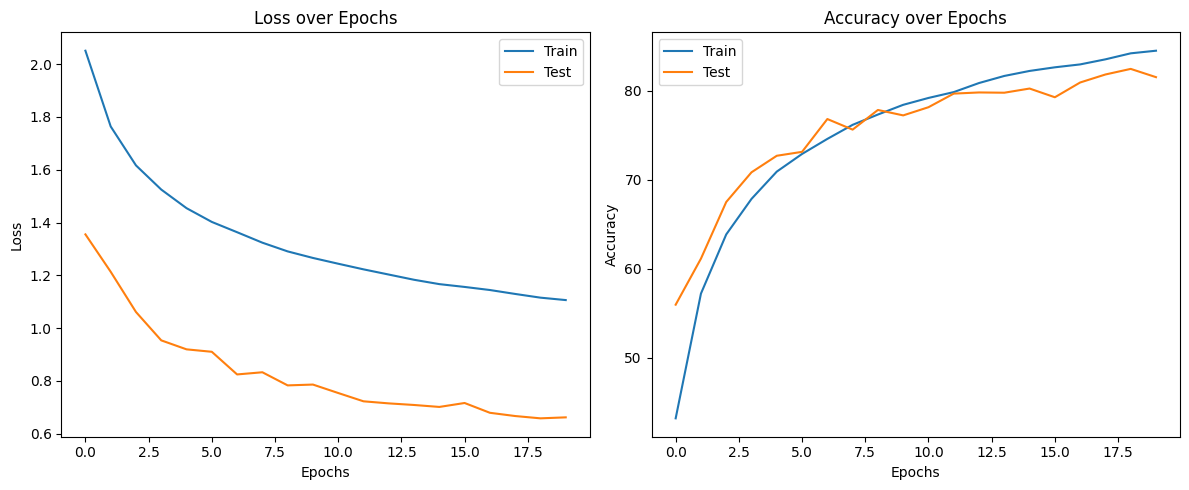

In [9]:
# Plotting the metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


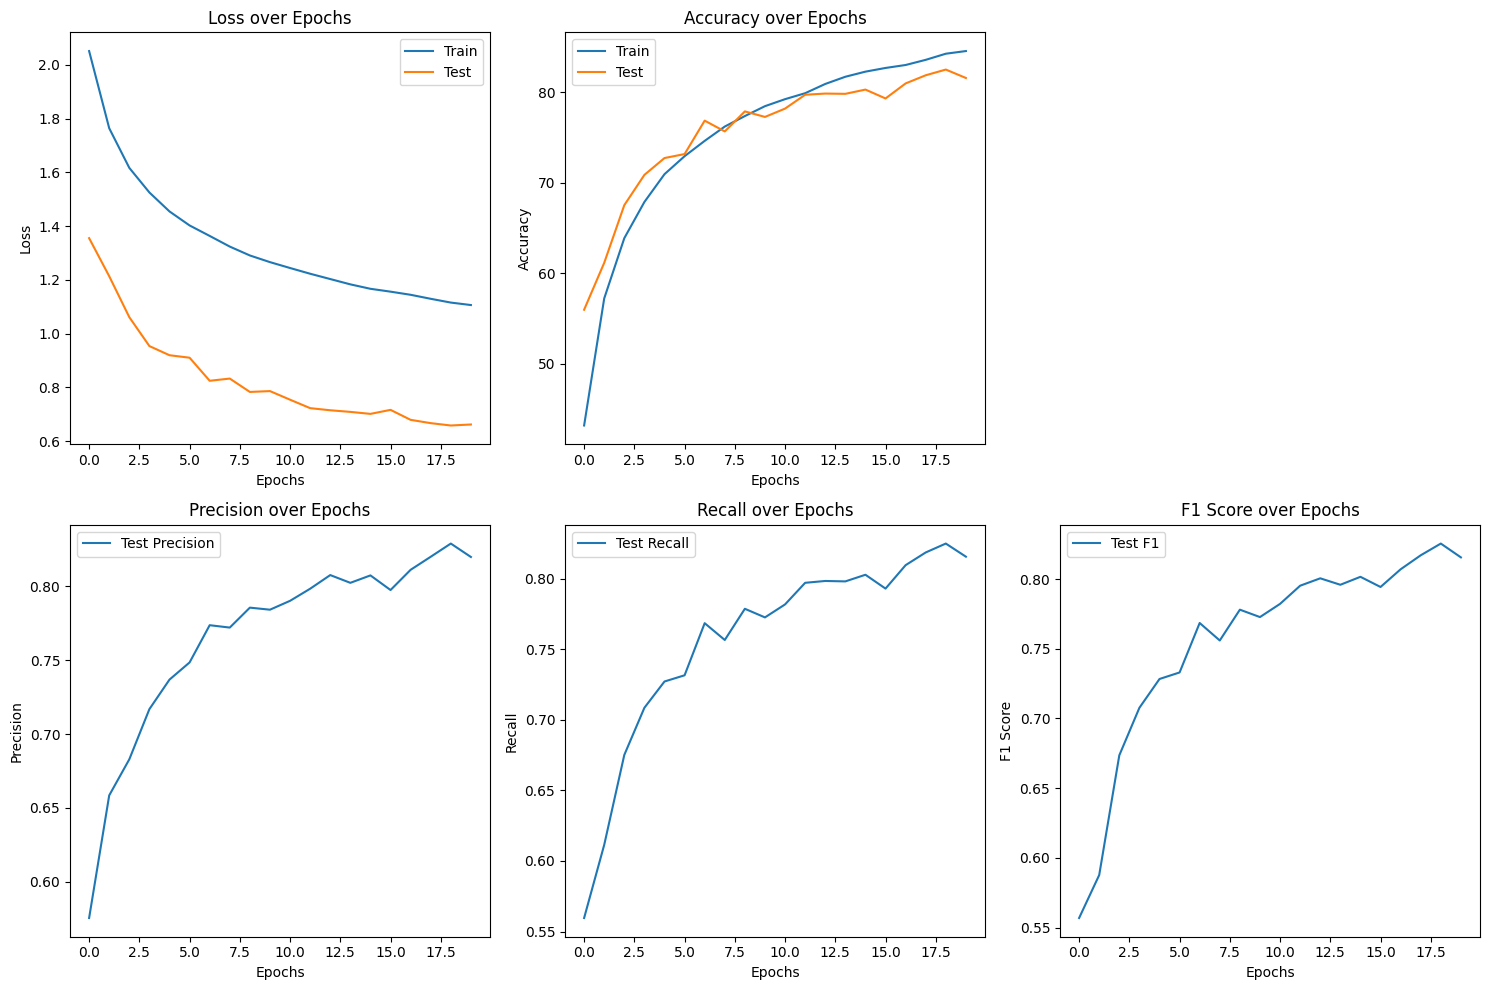

In [11]:
# Plotting the metrics
plt.figure(figsize=(15, 10))

# Plotting Loss
plt.subplot(2, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Precision
plt.subplot(2, 3, 4)
plt.plot(test_precisions, label='Test Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plotting Recall
plt.subplot(2, 3, 5)
plt.plot(test_recalls, label='Test Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plotting F1
plt.subplot(2, 3, 6)
plt.plot(test_f1s, label='Test F1')
plt.title('F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
